## About WIS
Good ressources:
-  Supplement of Cramer et al.
- code cramer et al. here https://github.com/reichlab/covid19-forecast-evals
- obviously https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008618#sec015
- [git clone https://github.com/adrian-lison/interval-scoring.git](https://github.com/adrian-lison/interval-scoring/tree/master) Adrian Lison's code for WIS
- https://epiforecasts.io/scoringutils/ Scoring utils package -- perhaps best to use ?

In [129]:
from interval_scoring import scoring
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [130]:
# A modification of Lison's code that splits the calibration in underprediction and overprediction
def weighted_interval_score_fast(
    observations, alphas, q_dict, weights=None, percent=False, check_consistency=True
):
    """
    Compute weighted interval scores for an array of observations and a number of different predicted intervals.
    
    This function implements the WIS-score (2). A dictionary with the respective (alpha/2)
    and (1-(alpha/2)) quantiles for all alpha levels given in `alphas` needs to be specified.
    
    This is a more efficient implementation using array operations instead of repeated calls of `interval_score`.
    
    Parameters
    ----------
    observations : array_like
        Ground truth observations.
    alphas : iterable
        Alpha levels for (1-alpha) intervals.
    q_dict : dict
        Dictionary with predicted quantiles for all instances in `observations`.
    weights : iterable, optional
        Corresponding weights for each interval. If `None`, `weights` is set to `alphas`, yielding the WIS^alpha-score.
    percent: bool, optional
        If `True`, score is scaled by absolute value of observations to yield a percentage error. Default is `False`.
    check_consistency: bool, optional
        If `True`, quantiles in `q_dict` are checked for consistency. Default is `True`.
        
    Returns
    -------
    total : array_like
        Total weighted interval scores.
    sharpness : array_like
        Sharpness component of weighted interval scores.
    calibration : array_like
        Calibration component of weighted interval scores.
        
    (2) Bracher, J., Ray, E. L., Gneiting, T., & Reich, N. G. (2020). Evaluating epidemic forecasts in an interval format. arXiv preprint arXiv:2005.12881.
    """
    if weights is None:
        weights = np.array(alphas)/2

    if not all(alphas[i] <= alphas[i + 1] for i in range(len(alphas) - 1)):
        raise ValueError("Alpha values must be sorted in ascending order.")

    reversed_weights = list(reversed(weights))

    lower_quantiles = [q_dict.get(alpha / 2) for alpha in alphas]
    upper_quantiles = [q_dict.get(1 - (alpha / 2)) for alpha in reversed(alphas)]
    if any(q is None for q in lower_quantiles) or any(
        q is None for q in upper_quantiles
    ):
        raise ValueError(
            f"Quantile dictionary does not include all necessary quantiles."
        )

    lower_quantiles = np.vstack(lower_quantiles)
    upper_quantiles = np.vstack(upper_quantiles)

    # Check for consistency
    if check_consistency and np.any(
        np.diff(np.vstack((lower_quantiles, upper_quantiles)), axis=0) < 0
    ):
        raise ValueError("Quantiles are not consistent.")

    lower_q_alphas = (2 / np.array(alphas)).reshape((-1, 1))
    upper_q_alphas = (2 / np.array(list(reversed(alphas)))).reshape((-1, 1))

    # compute score components for all intervals
    sharpnesses = np.flip(upper_quantiles, axis=0) - lower_quantiles

    lower_calibrations = (
        np.clip(lower_quantiles - observations, a_min=0, a_max=None) * lower_q_alphas
    )
    upper_calibrations = (
        np.clip(observations - upper_quantiles, a_min=0, a_max=None) * upper_q_alphas
    )
    calibrations = lower_calibrations + np.flip(upper_calibrations, axis=0)
    upper_calibrations = np.flip(upper_calibrations, axis=0)
    lower_calibrations = lower_calibrations

    # scale to percentage absolute error
    if percent:
        sharpnesses = sharpnesses / np.abs(observations)
        calibrations = calibrations / np.abs(observations)
        raise ValueError("Not Supported with the calibration split")

    totals = sharpnesses + calibrations

    # weigh scores
    weights = np.array(weights).reshape((-1, 1))

    sharpnesses_weighted = sharpnesses * weights
    calibrations_weighted = calibrations * weights
    upper_calibrations_weighted = upper_calibrations * weights
    lower_calibrations_weighted = lower_calibrations * weights
    totals_weighted = totals * weights

    # normalize and aggregate all interval scores
    weights_sum = np.sum(weights)

    sharpnesses_final = np.sum(sharpnesses_weighted, axis=0) / weights_sum
    calibrations_final = np.sum(calibrations_weighted, axis=0) / weights_sum
    upper_calibrations_final = np.sum(upper_calibrations_weighted, axis=0) / weights_sum
    lower_calibrations_final = np.sum(lower_calibrations_weighted, axis=0) / weights_sum
    totals_final = np.sum(totals_weighted, axis=0) / weights_sum

    return totals_final, sharpnesses_final, calibrations_final, lower_calibrations_final, upper_calibrations_final



In [131]:
pd.DataFrame.reset_index?

Signature:
pd.DataFrame.reset_index(
    self,
    level: 'IndexLabel' = None,
    *,
    drop: 'bool' = False,
    inplace: 'bool' = False,
    col_level: 'Hashable' = 0,
    col_fill: 'Hashable' = '',
    allow_duplicates: 'bool | lib.NoDefault' = <no_default>,
    names: 'Hashable | Sequence[Hashable]' = None,
) -> 'DataFrame | None'
Docstring:
Reset the index, or a level of it.

Reset the index of the DataFrame, and use the default one instead.
If the DataFrame has a MultiIndex, this method can remove one or more
levels.

Parameters
----------
level : int, str, tuple, or list, default None
    Only remove the given levels from the index. Removes all levels by
    default.
drop : bool, default False
    Do not try to insert index into dataframe columns. This resets
    the index to the default integer index.
inplace : bool, default False
    Whether to modify the DataFrame rather than creating a new one.
col_level : int or str, default 0
    If the columns have multiple levels, dete

In [132]:
def score_Nwk_forecasts(gt, forecasts, n=4) -> pd.DataFrame: 
    if isinstance(gt, str):
        gt = pd.read_csv(gt)
    if isinstance(forecasts, str):
        forecast = pd.read_csv(forecast)

    # take only the locations and dates that are forecasted
    gt = gt[gt["location"].isin(forecasts["location"])]
    gt = gt[gt["date"].isin(forecasts.target_end_date)]

    #first_forecast_date = datetime.datetime.strptime(forecasts["target_end_date"].sort_values()[0], "%Y-%m-%d").date()
    #target_dates = pd.date_range(first_forecast_date, first_forecast_date + datetime.timedelta(days=n*7), freq="W-SAT").date

    gt_piv = gt.pivot(index="date", columns="location", values="value").sort_index()


    target_dict = dict(zip(gt_piv.index, [f"{n} wk ahead" for n in range(1,n+1)]))
    
    # Alpha for WIS
    alphas=np.array(sorted(forecasts["quantile"].unique()))[:11]*2
    
    # gt_piv.index should be similar to target_dict.keys() apart from format

    all_targets = []
    
    for target in target_dict.keys():
        f = forecasts[forecasts["target_end_date"] == target]
        q_dict = {}
        for q in f["quantile"].unique():
            q_dict[float(q)] = f[f["quantile"]==q].pivot(index=["target_end_date"], columns="location", values="value").sort_index().to_numpy().ravel()
        wis_total, wis_sharpness, wis_calibration, underprediction, overprediction =   weighted_interval_score_fast(observations=gt_piv.loc[target].to_numpy(), 
                                                                                        alphas=alphas, 
                                                                                        q_dict=q_dict, 
                                                                                        weights=alphas/2)
        df = pd.DataFrame([wis_total, wis_sharpness, wis_calibration, underprediction, overprediction], index = ["wis_total", "wis_sharpness", "wis_calibration", "wis_underprediction", "wis_overprediction"], columns=gt_piv.columns)
        df["target"] = target_dict[target]
        df["target_end_date"] = target    
        all_targets.append(df)

    
    return pd.concat(all_targets).reset_index(names="wis_type").set_index(["target", "target_end_date"])

In [133]:
fdates = pd.date_range("2022-11-14", "2023-05-15", freq="W-MON")

gt = pd.read_csv("Flusight/Flusight-forecast-data/data-truth/truth-Incident Hospitalizations.csv")

scores = {}
for date in tqdm(fdates):
    date = date.date()
    try:
        forecasts = pd.read_csv(f"Flusight/Flusight-forecast-data/data-forecasts/UNC_IDD-InfluPaint/{str(date)}-UNC_IDD-InfluPaint.csv")
        #forecasts = pd.read_csv(f"Flusight/Flusight-forecast-data/data-forecasts/JHU_IDD-covidSP/{str(date)}-JHU_IDD-covidSP.csv")
        forecasts = pd.read_csv(f"Flusight/Flusight-forecast-data/data-forecasts/MOBS-GLEAM_FLUH/{str(date)}-MOBS-GLEAM_FLUH.csv")
        forecasts = forecasts[forecasts["type"]=="quantile"]
        this_date=True
    except FileNotFoundError:
        print(f"skipping {date}")
        this_date=False
    if this_date:
        wis_all = score_Nwk_forecasts(gt, forecasts)
        scores[date] = wis_all

 22%|██▏       | 6/27 [00:00<00:00, 24.79it/s]

skipping 2022-11-28


 59%|█████▉    | 16/27 [00:00<00:00, 23.09it/s]

skipping 2023-01-30


100%|██████████| 27/27 [00:01<00:00, 21.76it/s]


In [134]:
scores

{datetime.date(2022, 11, 14): location                               wis_type          01          02  \
 target     target_end_date                                                
 1 wk ahead 2022-11-19                 wis_total  455.264752   84.159035   
            2022-11-19             wis_sharpness   43.338560    5.080862   
            2022-11-19           wis_calibration  411.926192   79.078172   
            2022-11-19       wis_underprediction  411.926192    0.000000   
            2022-11-19        wis_overprediction    0.000000   79.078172   
 2 wk ahead 2022-11-26                 wis_total   70.952279  196.724726   
            2022-11-26             wis_sharpness   49.197758    7.037717   
            2022-11-26           wis_calibration   21.754521  189.687010   
            2022-11-26       wis_underprediction   21.754521    0.000000   
            2022-11-26        wis_overprediction    0.000000  189.687010   
 3 wk ahead 2022-12-03                 wis_total  586.41128

In [135]:
all_scores = pd.concat(scores, names=["forecast_date", "target", "target_end_date"])
wis_total = all_scores[all_scores["wis_type"] == "wis_total"].drop("wis_type", axis=1)
wis_total  = pd.melt(wis_total , var_name="location", value_name="wis_total",ignore_index=False).reset_index()

wis_underprediction = all_scores[all_scores["wis_type"] == "wis_underprediction"].drop("wis_type", axis=1)
wis_underprediction = pd.melt(wis_underprediction , var_name="location", value_name="wis_underprediction",ignore_index=False).reset_index()

wis_overprediction = all_scores[all_scores["wis_type"] == "wis_overprediction"].drop("wis_type", axis=1)
wis_overprediction = pd.melt(wis_overprediction , var_name="location", value_name="wis_overprediction",ignore_index=False).reset_index()

wis_sharpness = all_scores[all_scores["wis_type"] == "wis_sharpness"].drop("wis_type", axis=1)
wis_sharpness = pd.melt(wis_sharpness , var_name="location", value_name="wis_sharpness",ignore_index=False).reset_index()

wis_total 

,forecast_date,target,target_end_date,location,wis_total
0,2022-11-14,1 wk ahead,2022-11-19,01,455.264752
1,2022-11-14,2 wk ahead,2022-11-26,01,70.952279
2,2022-11-14,3 wk ahead,2022-12-03,01,586.411281
3,2022-11-14,4 wk ahead,2022-12-10,01,259.323903
4,2022-11-21,1 wk ahead,2022-11-26,01,75.774804
...,...,...,...,...,...
5195,2023-05-08,4 wk ahead,2023-06-03,50,0.020372
5196,2023-05-15,1 wk ahead,2023-05-20,50,6.353392
5197,2023-05-15,2 wk ahead,2023-05-27,50,0.121444
5198,2023-05-15,3 wk ahead,2023-06-03,50,0.022976


In [136]:
all_scores

location                                             wis_type          01  \
forecast_date target     target_end_date                                    
2022-11-14    1 wk ahead 2022-11-19                 wis_total  455.264752   
                         2022-11-19             wis_sharpness   43.338560   
                         2022-11-19           wis_calibration  411.926192   
                         2022-11-19       wis_underprediction  411.926192   
                         2022-11-19        wis_overprediction    0.000000   
...                                                       ...         ...   
2023-05-15    4 wk ahead 2023-06-10                 wis_total    9.501094   
                         2023-06-10             wis_sharpness    8.188184   
                         2023-06-10           wis_calibration    1.312910   
                         2023-06-10       wis_underprediction    1.312910   
                         2023-06-10        wis_overprediction    0.000000   

location                                         02          04          05  \
forecast_date target     target_end_date                                      
2022-11-14    1 wk ahead 2022-11-19       84.159035  464.157208  262.800835   
                         2022-11-19        5.080862   33.535239   31.524465   
                         2022-11-19       79.078172  430.621969  231.276370   
                         2022-11-19        0.000000    0.000000  231.276370   
                         2022-11-19       79.078172  430.621969    0.000000   
...                                             ...         ...         ...   
2023-05-15    4 wk ahead 2023-06-10       11.190372   43.571116   16.168490   
                         2023-06-10        0.249453   24.315098    4.789934   
                         2023-06-10       10.940919   19.256018   11.378556   
                         2023-06-10        0.000000    0.000000   11.378556   
                         2023-06-10       10.940919   19.256018    0.000000   

location                                           06          08         09  \
forecast_date target     target_end_date                                       
2022-11-14    1 wk ahead 2022-11-19       1788.607904  194.733717  77.399893   
                         2022-11-19        142.445855   13.842129  13.379881   
                         2022-11-19       1646.162049  180.891589  64.020012   
                         2022-11-19          0.000000    0.000000   0.000000   
                         2022-11-19       1646.162049  180.891589  64.020012   
...                                               ...         ...        ...   
2023-05-15    4 wk ahead 2023-06-10         23.236761   12.691466   4.142232   
                         2023-06-10         18.247702    5.689278   4.142232   
                         2023-06-10          4.989059    7.002188   0.000000   
                         2023-06-10          0.000000    7.002188   0.000000   
                         2023-06-10          4.989059    0.000000   0.000000   

location                                          10          11  ...  \
forecast_date target     target_end_date                          ...   
2022-11-14    1 wk ahead 2022-11-19       146.853738  105.585387  ...   
                         2022-11-19         4.190485    6.899094  ...   
                         2022-11-19       142.663252   98.686292  ...   
                         2022-11-19         0.000000   98.686292  ...   
                         2022-11-19       142.663252    0.000000  ...   
...                                              ...         ...  ...   
2023-05-15    4 wk ahead 2023-06-10         1.188184    1.544858  ...   
                         2023-06-10         1.188184    0.669584  ...   
                         2023-06-10         0.000000    0.875274  ...   
                         2023-06-10         0.000000    0.000000  ...   
                         2023-06-10         0.000000 

<Axes: xlabel='forecast_date', ylabel='target'>

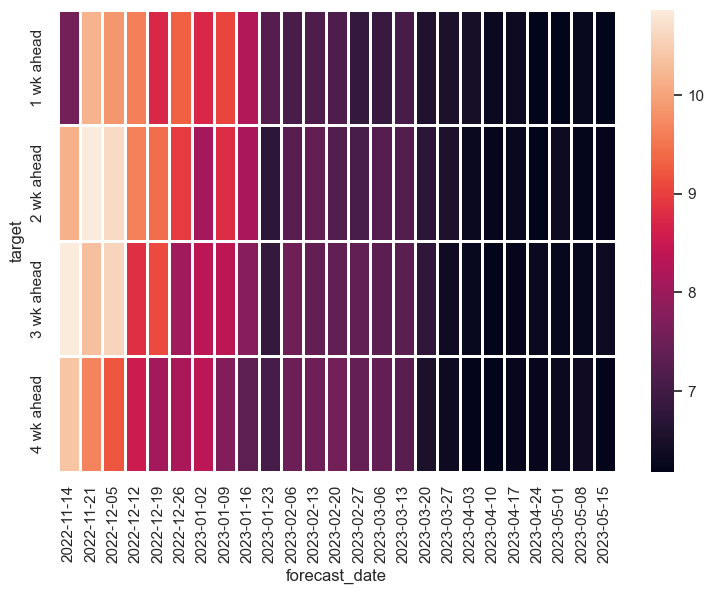

In [137]:
tp = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(np.log(tp), annot=False, fmt="", linewidths=1, ax=ax)

/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


<Axes: xlabel='forecast_date', ylabel='location'>

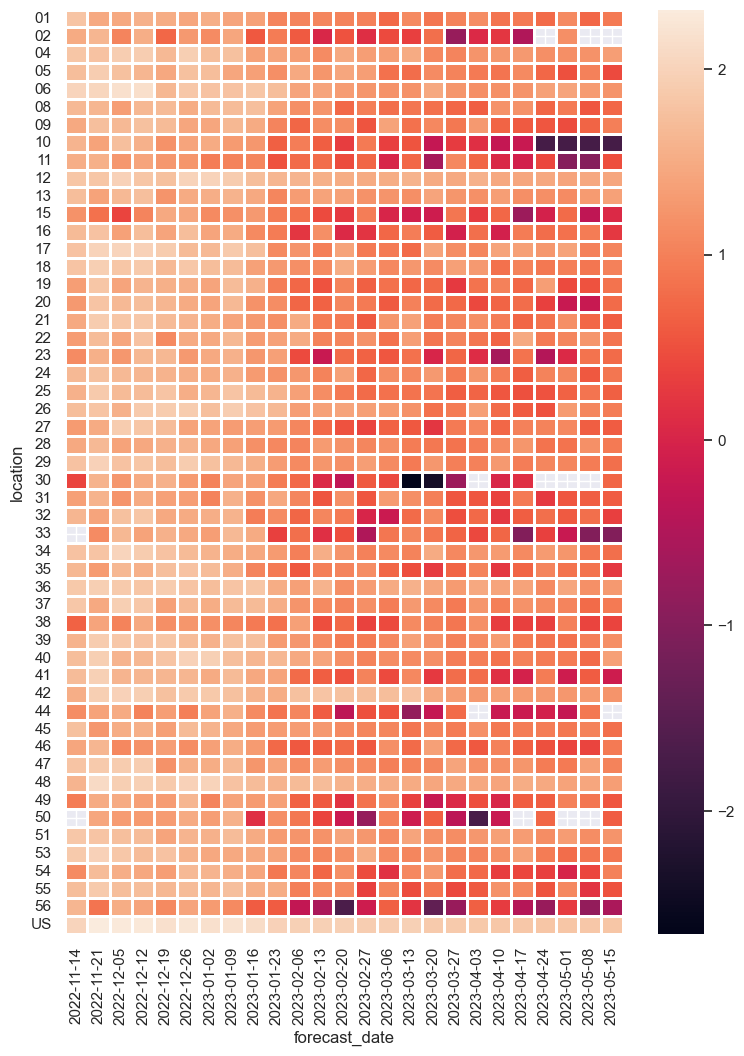

In [138]:
tp = wis_total[wis_total["target"]=="1 wk ahead"].pivot(values="wis_total", index="location", columns="forecast_date")
tp = np.log(tp)
f, ax = plt.subplots(figsize=(9, 12))
sns.heatmap(np.log(tp), annot=False, fmt="", linewidths=1, ax=ax)

In [139]:
# tp = wis_total.pivot(values="wis_total", index="location", columns=["forecast_date","target"])
# tp = np.log(tp)
# f, ax = plt.subplots(figsize=(12, 12), dpi=300)
# sns.heatmap(np.log(tp), annot=False, fmt="", linewidths=1, ax=ax)

0.618857866934123


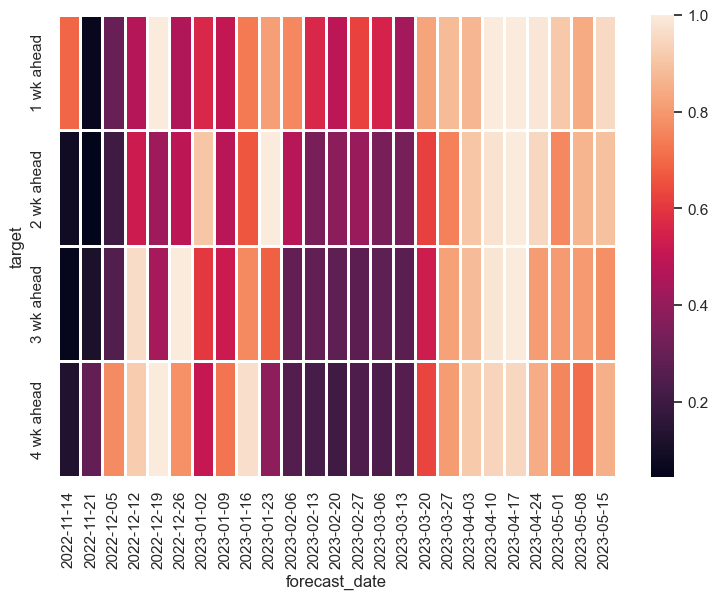

In [140]:
tp1 = wis_underprediction[wis_underprediction["location"]=="US"].pivot(values="wis_underprediction", index="target", columns="forecast_date")
tp2 = wis_overprediction[wis_overprediction["location"]=="US"].pivot(values="wis_overprediction", index="target", columns="forecast_date")

tp1 = wis_sharpness[wis_sharpness["location"]=="US"].pivot(values="wis_sharpness", index="target", columns="forecast_date")
tp2 = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(tp1/tp2, annot=False, fmt="", linewidths=1, ax=ax)
print((tp1/tp2).mean().mean())

0.0751593892153663


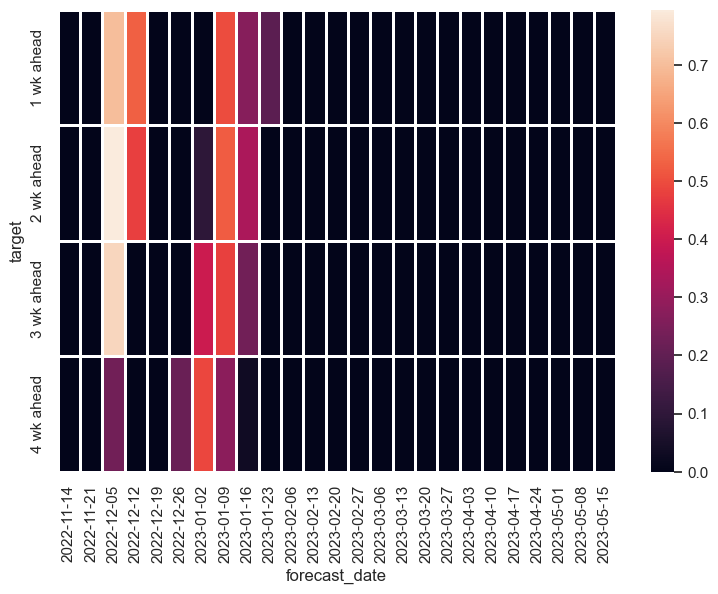

In [141]:
tp1 = wis_underprediction[wis_underprediction["location"]=="US"].pivot(values="wis_underprediction", index="target", columns="forecast_date")
#tp2 = wis_overprediction[wis_overprediction["location"]=="US"].pivot(values="wis_overprediction", index="target", columns="forecast_date")

tp2 = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(tp1/tp2, annot=False, fmt="", linewidths=1, ax=ax)
print((tp1/tp2).mean().mean())

0.3059827438505106


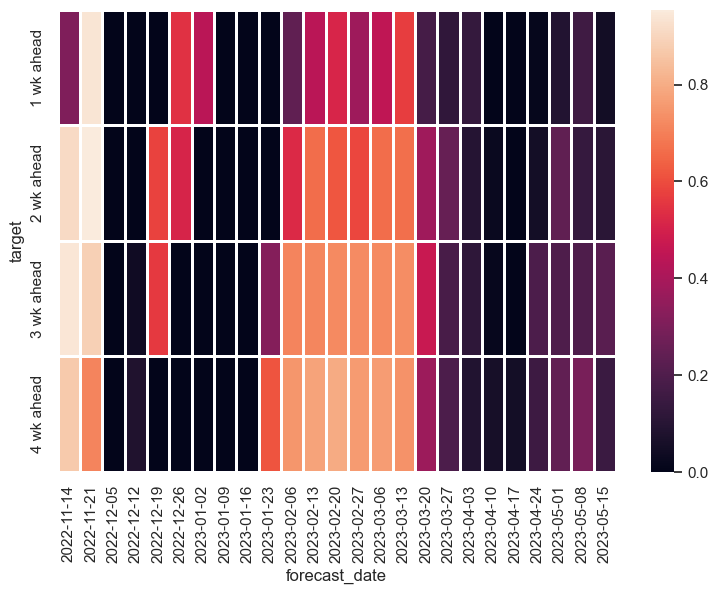

In [142]:
tp1 = wis_overprediction[wis_overprediction["location"]=="US"].pivot(values="wis_overprediction", index="target", columns="forecast_date")

tp2 = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(tp1/tp2, annot=False, fmt="", linewidths=1, ax=ax)
print((tp1/tp2).mean().mean())